In [127]:
# Split up the dataset randomly into 80% train set, 10% dev set, 10% test set.
# Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
import random # shuffle the list of words to get an even distribution
import torch

words = open('../names.txt', 'r').read().splitlines()
random.seed(230)
random.shuffle(words)


In [128]:
# Map the words to indexes
chars = sorted(list(set(''.join(words)))) # get the unique characters through the set() method
stoi = {s:i +1 for i,s in enumerate(chars)} # string to index
stoi['.'] = 0 # end character

itos = {i:s for s,i in stoi.items()} # index to string
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [130]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  xs, ys = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      xs.append(context)
      ys.append(ix)
      context = context[1:] + [ix] # crop and append

  xs = torch.tensor(xs)
  ys = torch.tensor(ys)
  return xs, ys

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

In [183]:
## SET UP MODEL PARAMETERS

import torch.nn.functional as F

gain = 5/3 # we need a gain because we are using the tanh activation function; squashes, add a gain to get back to normal std
dim_emb = 2 # dimensionality of the embedding
n_hidden = 100 # number of hidden units

# set up the model drivers
g = torch.Generator().manual_seed(2147483648)
emb_lookup = torch.randn((len(chars) + 1, dim_emb), generator=g) #also written as 'C'. Can scale up dimensionality to capture more nuanced patterns
W1 = torch.randn((dim_emb * block_size, n_hidden), generator=g)  * (gain / (dim_emb * block_size) **0.5) 
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, len(chars) + 1), generator=g) * (gain / n_hidden**0.5) # ending back up with 27 possible outputs / chars
b2 = torch.randn(len(chars) + 1, generator=g) * 0

bngain = torch.ones((1, n_hidden)) # scale
bnbias = torch.zeros((1, n_hidden)) # shift
bnmean_running = torch.zeros((1, n_hidden)) # running mean
bnstd_running = torch.ones((1, n_hidden)) # running std

# put all of the parameters in one array for neatness -- you can sum all these to get total param count
parameters = [emb_lookup, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [117]:
(torch.randn(10000) * 0.2).std()

# Whatever you multiply by will be the standard deviation
# In general when you do a kaiming_normal init, you want to set the standard deviation to:
# gain / (sqrt(fan_in)) where fan_in is the number of inputs to the layer
# let's do this for the parameters above!

tensor(0.2037)

(array([2.06031626e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.03015813e-04, 6.18094879e-05, 2.67841114e-04, 3.50253765e-04,
        4.12063253e-04, 8.65332831e-04, 1.85428464e-03, 2.82263328e-03,
        5.08898117e-03, 7.49955120e-03, 1.30211988e-02, 2.15097018e-02,
        3.27178223e-02, 4.96536220e-02, 7.47894804e-02, 1.12534474e-01,
        1.61034319e-01, 2.24079997e-01, 2.92667925e-01, 3.67148358e-01,
        4.28628196e-01, 4.44162980e-01, 4.34644319e-01, 3.77058480e-01,
        3.09583122e-01, 2.34319769e-01, 1.71665551e-01, 1.22403389e-01,
        8.14030956e-02, 5.25174616e-02, 3.69002643e-02, 2.25398599e-02,
        1.44840233e-02, 8.71513780e-03, 5.13018750e-03, 3.29650602e-03,
        1.97790361e-03, 1.33920557e-03, 5.76888554e-04, 3.09047440e-04,
        1.03015813e-04, 1.85428464e-04, 1.03015813e-04, 2.06031626e-05,
        4.12063253e-05, 2.06031626e-05]),
 array([-6.20669937, -5.96401818, -5.72133699, -5.47865581, -5.23597462,
        -4.99329343, 

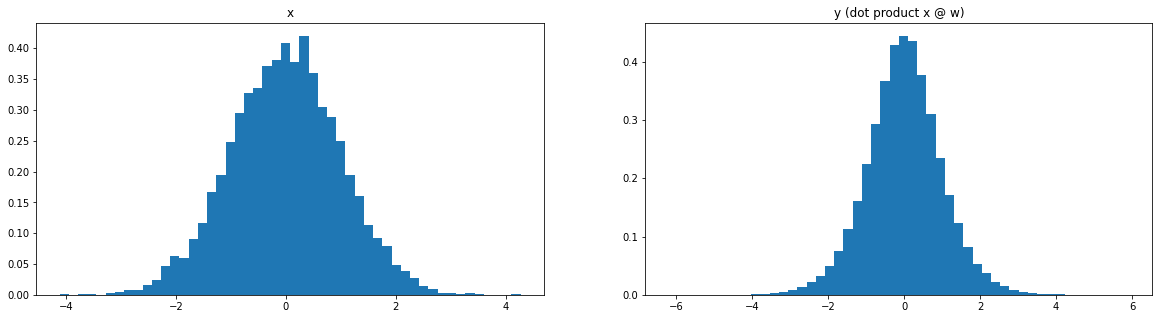

In [118]:
import matplotlib.pyplot as plt

x = torch.randn(1000,10) # x is drawn from a gaussian
w = torch.randn(10,200) / (10**0.5) # the divisor is the 'fan-in' -- ie. number of inputs to the neuron -- square rooted
y = x @ w # gets the preactivations of the neurons -- giving a sense for what happens when you multiply two uniform gaussians

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('x')
plt.hist(x.view(-1).tolist(), 50, density=True)

plt.subplot(122)
plt.title('y (dot product x @ w)')
plt.hist(y.view(-1).tolist(), 50, density=True)

# you can see that after the dot product, the distribution of y is much more spread out than x (ie. high std)
# this is undesirable - we want to keep the distribution of the preactivations as close to the input as possible
# we will normalize the preactivations, and also make sure add a gain (because tanh is a squashing function)

In [213]:
# Use this to try out different learning rates
lre = torch.linspace(-4, -2, 5) # creates a tensor of 2000 linearly spaced points between 10^-2 and 10^1. Represents learning rate in exponents in log scale (base 10)
lrs = 10**lre # transforms into decimal form (ie instead of 10^-3, you have 0.01)
lrs

tensor([1.0000e-04, 3.1623e-04, 1.0000e-03, 3.1623e-03, 1.0000e-02])

In [180]:
max_steps = 1000
loss_values = []
learning_rates = []
steps = []

In [181]:
## TRAINING THE MODEL

# Basically the same thing as running a validation / test run except with gradient updates
for k in range(max_steps): #running a loop as we're running a bunch of forward passes to get loss and optimize
    ## Make a mini batch
    # In this example, we will grab 32 rows of the lookup table
    # This is random, which can help with generalization
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    ## Forward pass
    # embed the input xs tensor into the lookup table
    # instead of grabbing the entire dataset as one batch to train, we get mini batches
    xs_embeddings = emb_lookup[Xtr[ix]] # feed into the two subsequent layers

    ### Batch Normalization Layer

    # standardizing these so that they are roughly gaussian before tanh
    # guassian distribution: inherantly lower probability of extreme values
    # should only be forced to be gaussian at intialization, not during training -- we want distribution to be able to move around
    # so we introduce 'scale' and 'shift' parameters to the network
    pre_activations = xs_embeddings.view(-1, 6) @  W1 + b1

    # estimate batch statistics as we go so that we can pass one input through easily during val later
    bnmeani = pre_activations.mean(0, keepdim=True)
    bnstdi = pre_activations.std(0, keepdim=True)
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # nudging a bit toward current batch
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi # no_grad as we aren't edting activations wrt these

    pre_activations = bngain * (pre_activations - bnmeani) / bnstdi + bnbias
    

    # continue feeding into the subsequent layers
    hidden_layer = torch.tanh(pre_activations)
    logits = hidden_layer @ W2 + b2 #matrix multiplication, give us the log counts
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())

    # TODO: need to understand the L2 regularization from part one. Also less clear about functions below
    # For example: 1) why are we going through all the parameters, and 2) why aren't we updating weights.data, but all

    ## Backward pass
    for p in parameters:
        p.data += -(0.56) * p.grad
    steps.append(k)
    loss_values.append(loss.log10().item())   
    

111.09542083740234
129.64906311035156
105.53292083740234
112.801025390625
93.85327911376953
94.66902923583984
109.12919616699219
94.07867431640625
105.16877746582031
115.57943725585938
132.36805725097656
90.20169067382812
112.61181640625
113.2070541381836
128.31198120117188
107.0411376953125
106.46853637695312
87.80364227294922
91.99445343017578
102.49115753173828
96.21231079101562
112.21590423583984
94.65594482421875
102.81642150878906
96.92082977294922
95.43387603759766
89.78109741210938
99.90521240234375
108.52433013916016
116.97299194335938
102.79439544677734
92.76394653320312
101.39866638183594
98.2242660522461
95.70404815673828
114.72730255126953
98.08860778808594
99.297119140625
118.7228012084961
103.12265014648438
110.69859313964844
77.6546630859375
101.60702514648438
107.12835693359375
115.3597640991211
98.00385284423828
85.07032775878906
87.32162475585938
111.61026763916016
103.61692810058594
84.39122772216797
104.31578826904297
117.8583984375
113.57208251953125
107.559669494

In [214]:
# For getting the learning rate
max_steps = 50000
loss_values = []
learning_rates_loss = {}

for index, learning_rate in enumerate(lrs):
    # train model with this lrs
    g = torch.Generator().manual_seed(2147483648)
    emb_lookup = torch.randn((len(chars) + 1, dim_emb), generator=g) #also written as 'C'. Can scale up dimensionality to capture more nuanced patterns
    W1 = torch.randn((dim_emb * block_size, n_hidden), generator=g)  * (gain / (dim_emb * block_size) **0.5) 
    b1 = torch.randn(n_hidden, generator=g) * 0.01
    W2 = torch.randn((n_hidden, len(chars) + 1), generator=g) * (gain / n_hidden**0.5) # ending back up with 27 possible outputs / chars
    b2 = torch.randn(len(chars) + 1, generator=g) * 0

    bngain = torch.ones((1, n_hidden)) # scale
    bnbias = torch.zeros((1, n_hidden)) # shift
    bnmean_running = torch.zeros((1, n_hidden)) # running mean
    bnstd_running = torch.ones((1, n_hidden)) # running std

    # put all of the parameters in one array for neatness -- you can sum all these to get total param count
    parameters = [emb_lookup, W1, b1, W2, b2, bngain, bnbias]
    for p in parameters:
        p.requires_grad = True
    
    learning_rates_loss[index] = {"learning_rate": float(learning_rate), "loss": [], "steps": []}
    loss_accumulator = 0
    
    for k in range(max_steps):
        ## Make a mini batch
        # In this example, we will grab 32 rows of the lookup table
        # This is random, which can help with generalization
        ix = torch.randint(0, Xtr.shape[0], (32,))
        
        ## Forward pass
        # embed the input xs tensor into the lookup table
        # instead of grabbing the entire dataset as one batch to train, we get mini batches
        xs_embeddings = emb_lookup[Xtr[ix]] # feed into the two subsequent layers

        ### Batch Normalization Layer

        # standardizing these so that they are roughly gaussian before tanh
        # guassian distribution: inherantly lower probability of extreme values
        # should only be forced to be gaussian at intialization, not during training -- we want distribution to be able to move around
        # so we introduce 'scale' and 'shift' parameters to the network
        pre_activations = xs_embeddings.view(-1, 6) @  W1 + b1

        # estimate batch statistics as we go so that we can pass one input through easily during val later
        bnmeani = pre_activations.mean(0, keepdim=True)
        bnstdi = pre_activations.std(0, keepdim=True)
        with torch.no_grad():
            bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # nudging a bit toward current batch
            bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi # no_grad as we aren't edting activations wrt these

        pre_activations = bngain * (pre_activations - bnmeani) / bnstdi + bnbias
        

        # continue feeding into the subsequent layers
        hidden_layer = torch.tanh(pre_activations)
        logits = hidden_layer @ W2 + b2 #matrix multiplication, give us the log counts
        loss = F.cross_entropy(logits, Ytr[ix])
        print(loss.item())

        # TODO: need to understand the L2 regularization from part one. Also less clear about functions below
        # For example: 1) why are we going through all the parameters, and 2) why aren't we updating weights.data, but all

        ## Backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        ## Update
        for p in parameters:
            p.data += -(learning_rate) * p.grad

        # Accumulate loss
        loss_accumulator += loss.item()

        if (k + 1) % 10 == 0:
            # Every 10 steps, compute the average loss and reset the accumulator
            average_loss = loss_accumulator / 10
            learning_rates_loss[index]["loss"].append(average_loss)
            learning_rates_loss[index]["steps"].append(k)
            loss_accumulator = 0  # Reset accumulator

4.122208595275879
4.228639125823975
3.9749813079833984
3.959699869155884
3.7536020278930664
4.149662017822266
3.8791425228118896
4.047879695892334
4.033672332763672
4.252511978149414
3.942749500274658
3.9691572189331055
4.006781578063965
3.8799848556518555
4.233574867248535
3.856466054916382
4.043064594268799
3.7169137001037598
3.997507095336914
4.122668266296387
4.024870872497559
4.391965389251709
3.8100979328155518
4.357378959655762
4.140866279602051
4.174840450286865
4.117351531982422
3.9121057987213135
4.047136306762695
4.5069899559021
3.9012763500213623
4.110722064971924
4.041886806488037
3.9534459114074707
3.9391515254974365
4.184275150299072
4.514842510223389
4.251537799835205
4.10219669342041
4.150041103363037
4.233625411987305
3.8904905319213867
4.2118754386901855
4.280376434326172
4.030623912811279
3.598752975463867
4.293488025665283
4.465405464172363
4.366241931915283
3.952575922012329
3.8634207248687744
3.9210970401763916
3.760552406311035
4.047645092010498
3.83485436439514

(array([  4.,   7.,  14.,   6.,   8.,   8.,  14.,  26.,  36.,  60.,  76.,
         79.,  93.,  94., 118., 164., 153., 164., 185., 163., 169., 177.,
        152., 129., 173., 160., 164., 133., 113., 103.,  72.,  48.,  36.,
         27.,  13.,  20.,   9.,   7.,   4.,   1.,   5.,   8.,   3.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.]),
 array([-3.65178466e+00, -3.47798109e+00, -3.30417751e+00, -3.13037394e+00,
        -2.95657037e+00, -2.78276680e+00, -2.60896322e+00, -2.43515965e+00,
        -2.26135608e+00, -2.08755250e+00, -1.91374893e+00, -1.73994536e+00,
        -1.56614179e+00, -1.39233821e+00, -1.21853464e+00, -1.04473107e+00,
        -8.70927496e-01, -6.97123923e-01, -5.23320351e-01, -3.49516778e-01,
        -1.75713205e-01, -1.90963268e-03,  1.71893940e-01,  3.45697513e-01,
         5.19501085e-01,  6.93304658e-01,  8.67108231e-01,  1.04091180e+00,
         1.21471538e+00,  1.38851895e+00,  1.56232252e+00,  1.73612609e+00,
         1.90992967e+00,  2.08373324e+00,  2.25753

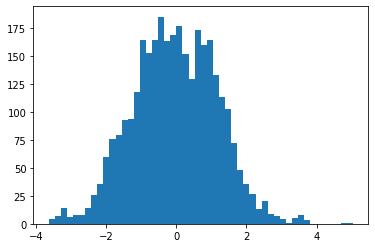

In [176]:
# CHECK HIDDEN LAYER ACTIVATIONS
# There are many very extreme values, which will all get squashed

plt.hist(pre_activations.view(-1).tolist(), 50)

(array([1.004e+03, 6.400e+01, 3.400e+01, 2.100e+01, 1.200e+01, 1.700e+01,
        1.300e+01, 1.700e+01, 7.000e+00, 9.000e+00, 1.000e+01, 7.000e+00,
        1.600e+01, 5.000e+00, 8.000e+00, 1.500e+01, 1.500e+01, 1.700e+01,
        1.700e+01, 6.000e+00, 9.000e+00, 1.300e+01, 2.000e+00, 7.000e+00,
        2.220e+02, 2.980e+02, 1.500e+01, 1.200e+01, 8.000e+00, 3.000e+00,
        7.000e+00, 1.200e+01, 1.000e+00, 4.000e+00, 1.100e+01, 6.000e+00,
        8.000e+00, 4.000e+00, 1.400e+01, 1.000e+01, 7.000e+00, 1.300e+01,
        6.000e+00, 9.000e+00, 1.600e+01, 1.800e+01, 1.200e+01, 4.400e+01,
        4.300e+01, 1.052e+03]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,

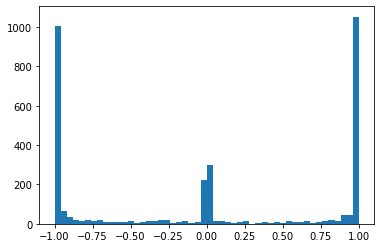

In [169]:
# CHECK ACTIVATION FUNCTION VALUES
# This is something that goes wrong in initializing nn's - too many +-1's
# This means that inputs to the tanh are two extreme, so they are getting squashed
# As the activation function approaches +-1, the gradient (ie. derivation of the function) approaches 0
# A backward pass function: self.grad += (1-t**2) * out.grad

plt.hist(hidden_layer.view(-1).tolist(), 50)

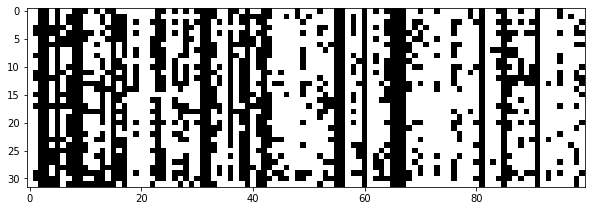

In [170]:
# PLOT HIDDEN LAYER ACTIVATIONS
# If there is an entire column of white, that means we have a dead neuron because the backward gradient was destroyed

plt.figure(figsize=(10, 10))
plt.imshow(hidden_layer.abs() > 0.99, cmap='gray', interpolation='nearest')

In [215]:
learning_rates_loss

{0: {'learning_rate': 9.999999747378752e-05,
  'loss': [4.040199947357178,
   3.976886773109436,
   4.148360347747802,
   4.114937591552734,
   4.132345604896545,
   3.9534374237060548,
   4.061010265350342,
   4.089081287384033,
   4.047451734542847,
   4.095969462394715,
   4.059765076637268,
   3.9874695539474487,
   4.083473205566406,
   4.020344567298889,
   4.0431266069412235,
   4.119792628288269,
   4.114580368995666,
   4.050612759590149,
   4.106227779388428,
   4.158253383636475,
   4.026712083816529,
   4.097636103630066,
   4.044072198867798,
   4.077925515174866,
   4.0766361951828,
   4.14604766368866,
   4.102070569992065,
   3.995489716529846,
   4.05923330783844,
   4.113655376434326,
   4.075359773635864,
   4.143477177619934,
   3.9878432750701904,
   4.058280968666077,
   4.0715563774108885,
   4.075753092765808,
   4.091820216178894,
   3.998008632659912,
   3.943909502029419,
   4.082943248748779,
   3.980513024330139,
   4.085111737251282,
   4.055527186393737,


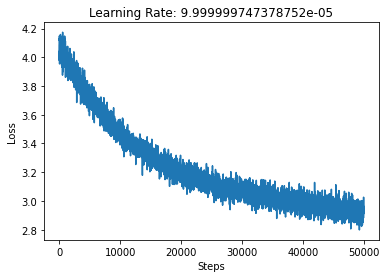

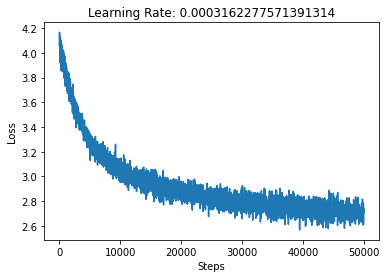

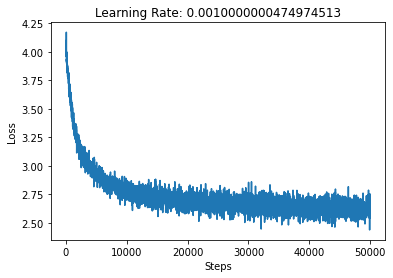

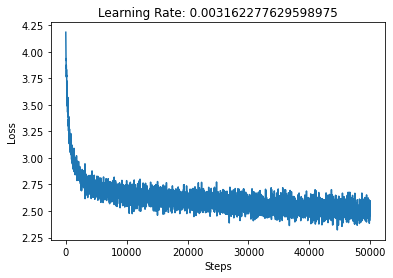

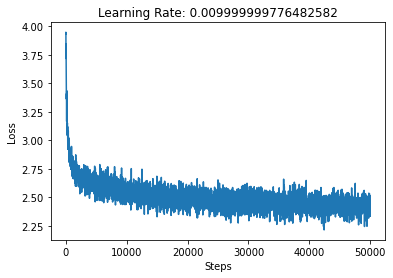

In [216]:
# PLOT LEARNING RATES TO LOSS RELATIONSHIP (Iteration One)

for k in learning_rates_loss:
    plt.plot(learning_rates_loss[k]["steps"], learning_rates_loss[k]["loss"])
    plt.title("Loss By Learning Rates") 
    plt.title(f'Learning Rate: {learning_rates_loss[k]["learning_rate"]}')
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.show()

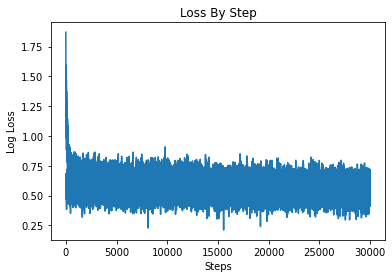

In [167]:
# PLOT STEPS TO LOSS RELATIONSHIP (Iteration Two, After Increasing Model Size)

plt.plot(steps, loss_values)
plt.title("Loss By Step")
plt.xlabel("Steps")
plt.ylabel("Log Loss")
plt.show()

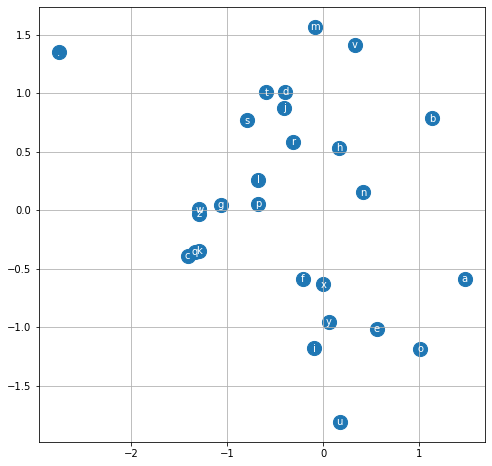

In [153]:
# PLOT EMBEDDINGS (Iteration Three)
# TODO: I don't know why this is returning embedded characters, yet.
# When characters are close to each other the neural net is treating them similarly

plt.figure(figsize=(8,8))
plt.scatter(emb_lookup[:, 0].data, emb_lookup[:,1].data, s=200) # each word has two dimensions / columns
for i in range(emb_lookup.shape[0]):
    plt.text(emb_lookup[i, 0].item(), emb_lookup[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [154]:
# CHECK TOTAL LOSS ON TRAIN_SET FORWARD PASS

# Do a forward pass (without updates)
@torch.no_grad()

def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

    xs_embeddings = emb_lookup[x]
    pre_activations = xs_embeddings.view(xs_embeddings.shape[0], -1) @  W1 
    pre_activations = bngain * (pre_activations - bnmean_running) / bnstd_running + bnbias
    hidden_layer = torch.tanh(pre_activations)

    logits = hidden_layer @ W2 + b2 # matrix multiplication, give us the log counts
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.411381244659424
val 2.410766124725342


In [ ]:
# SAMPLE FROM MODEL

g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Forward pass
        embeddings = emb_lookup[torch.tensor([context])]
        hidden_layer = torch.tanh(embeddings.view(1, -1) @ W1 + b1)
        logits = hidden_layer @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # Sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # Shift context window and track samples
        context = context[1:] + [ix]
        out.append(ix)

        # Break if end token detected
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mria.
mayahlieel.
ndynyal.
rethrstend.
leg.
aderedieliileli.
jelle.
eisennanar.
kayziohlara.
noshubergahi.
jest.
jair.
jelilentenof.
uba.
ghde.
jyleli.
ehs.
kay.
myskeyah.
hil.
